In [66]:
import os
from time import time
import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from python_speech_features import mfcc
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import signal

In [108]:
TRAIN_DIR = "Data/isolated_digits_ti_train_endpt"
TEST_DIR = "Data/isolated_digits_ti_test_endpt"

NUM_CEP = 13  # parameter for MFCC
NUM_LABELS = 11  # 1, 2, 3, 4, ...
PRINT_FREQ = 20 # how often progress of training is displayed
NUM_MODELS = 4 # no of Gaussians in GMM (k)
NUM_ITERS = 10 # no of iters for estimating GMM params
NUM_SAMPLES = 100 # no of samples from FFT amplitude from which GMMs are learned

### FFT for sample audio

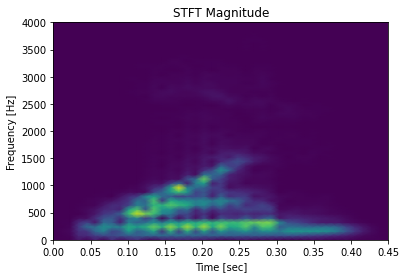

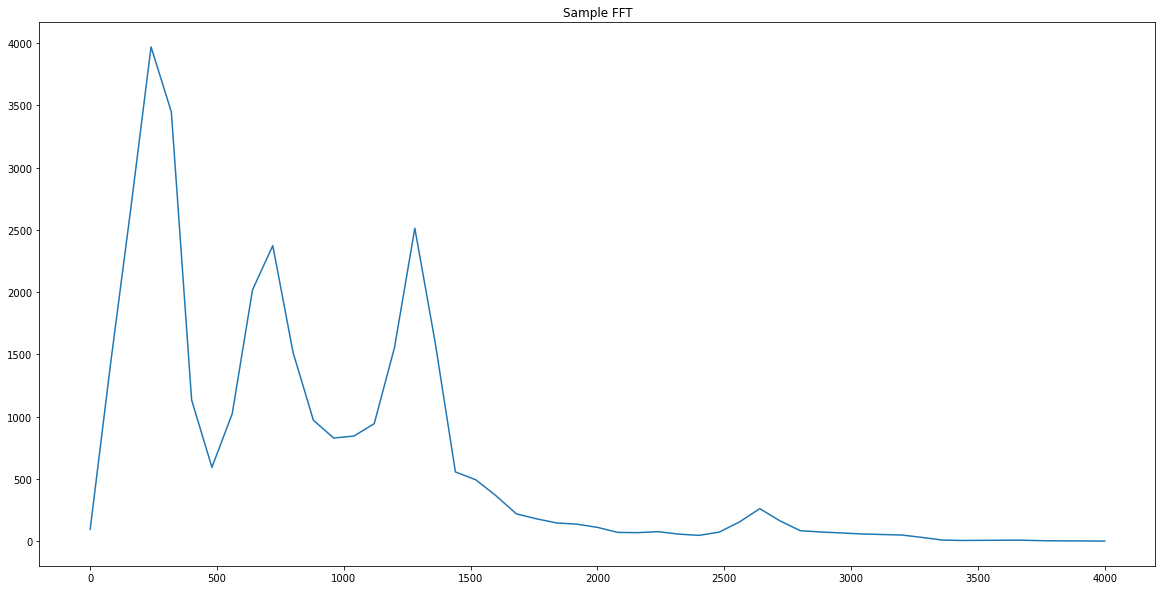

In [109]:
file_path = "Data/isolated_digits_ti_train_endpt/MAN/AE/1A_endpt.wav"
sampling_freq, audio = wavfile.read(file_path)

freq, t, Zxx = signal.stft(audio, sampling_freq, nperseg=100, noverlap=10, nfft=100)
plt.pcolormesh(t, freq, np.abs(Zxx), vmin=0, vmax=5000, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# ampl_fft - sample FFT from an arbitrarily chosen window (window No. 20)
ampl_fft = abs(Zxx[:, 20])

plt.figure(figsize=(20,10))
plt.plot(freq, ampl_fft)
plt.title('Sample FFT')
plt.show()


### Calculate frequencies samples according to FFT amplitude for a given frequency

In [110]:
def samples_from_fft(freqs, ampl):

    # TODO consider different solution
    ampl_sum = ampl.sum()
    if ampl_sum == 0 or np.isnan(ampl_sum):
        return np.random.choice(a=freqs, size=NUM_SAMPLES)

    return np.random.choice(a=freqs, size=NUM_SAMPLES, p=ampl/ampl_sum)


### GMM class with methods for EM algorithm 

In [111]:
class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)

        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,
                aweights=(weight/total_weight).flatten(),
                bias=True)

    def fit(self, X):
        self.initialize(X)

        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )

        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i] + 0.00001*np.random.rand(),
                cov=self.sigma[i] + 0.00001*np.random.rand())
            likelihood[:,i] = distribution.pdf(X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights

    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

    def get_features(self) -> np.ndarray:
        features = np.array([])
        features = np.concatenate((features, np.concatenate(self.mu, axis=0)))
        features = np.concatenate((features, np.array([float(s) for s in self.sigma])))

        return features.reshape((1, -1))


### Fit GMM to a given audio

In [112]:
freq_samples = samples_from_fft(freq, ampl_fft)
gmm = GMM(k=NUM_MODELS, max_iter=NUM_ITERS)
gmm.fit(freq_samples.reshape(freq_samples.shape[0],1))

### Plot results

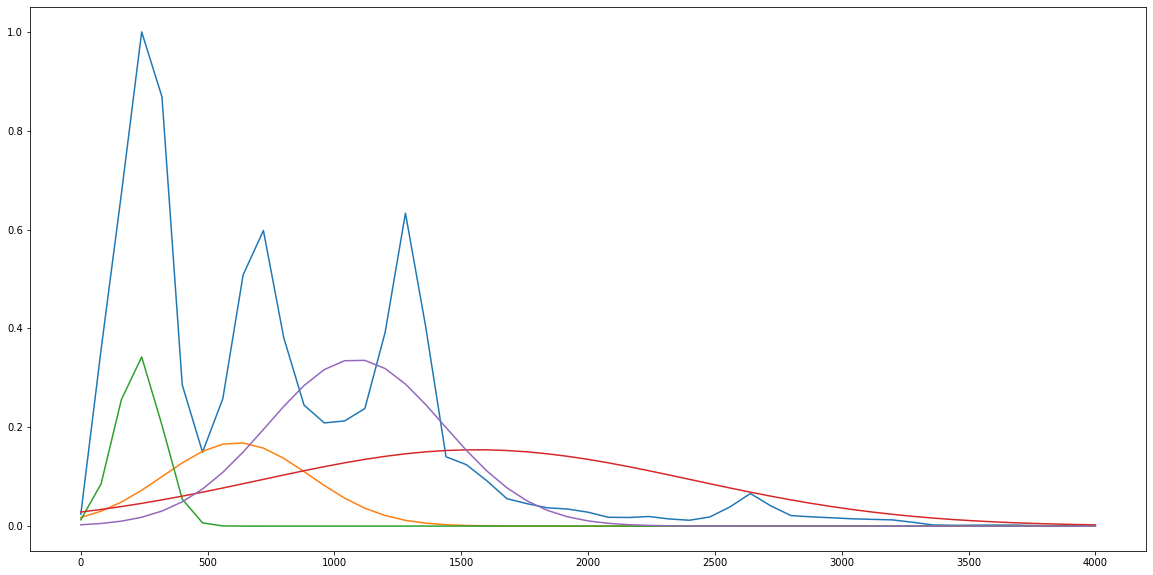

In [113]:
distributions = []
for i in range(NUM_MODELS):
    distributions.append(multivariate_normal(
        mean=gmm.mu[i],
        cov=gmm.sigma[i]))

plt.figure(figsize=(20,10))
plt.plot(freq, ampl_fft / max(ampl_fft))

for i in range(NUM_MODELS):
    plt.plot(freq, gmm.phi[i] * distributions[i].pdf(freq) / max(distributions[i].pdf(freq))) # PDF functions normalized and weighted by phi - prior probability for a given Gaussian

In [114]:
# Class to handle all HMM related processing
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                         covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)


In [118]:
Label = str
Features = np.ndarray
FeaturesByLabelsDict = Dict[Label, Features]
ModelLabelTuple = Tuple[HMMTrainer, Label]
ModelsList = List[ModelLabelTuple]

def extract_label(file_name: str) -> str:
    return file_name[0]

def get_test_files() -> [str]:
    test_files: List[str] = []
    for gender_dir_name in os.listdir(TEST_DIR):
        # MAN, WOMAN
        gender_dir = os.path.join(TEST_DIR, gender_dir_name)
        if not os.path.isdir(gender_dir):
            continue

        for person_dir_name in os.listdir(gender_dir):
            # AH, AR, ...
            person_dir = os.path.join(gender_dir, person_dir_name)

            for file_name in [x for x in os.listdir(person_dir) if x.endswith('.wav')]:
                file = os.path.join(person_dir, file_name)
                test_files.append(file)
    return test_files

def obtain_features() -> FeaturesByLabelsDict:
    features_by_label: Dict[str, np.ndarray] = {}

    processed_files = 0
    files_limit = 2_000
    for gender_dir_name in os.listdir(TRAIN_DIR):
        # MAN, WOMAN
        gender_dir = os.path.join(TRAIN_DIR, gender_dir_name)
        if not os.path.isdir(gender_dir):
            continue

        for person_dir_name in os.listdir(gender_dir):
            # AH, AR, ...
            person_dir = os.path.join(gender_dir, person_dir_name)

            for file_name in [x for x in os.listdir(person_dir) if x.endswith('.wav')]:

                label = extract_label(file_name)
                if label not in features_by_label:
                    features_by_label[label] = np.empty((0, NUM_MODELS*2))

                file_path = os.path.join(person_dir, file_name)
                sampling_freq, audio = wavfile.read(file_path)

                # GMM
                start_time = time()
                freq, _, Zxx = signal.stft(audio, sampling_freq, nperseg=100, noverlap=10, nfft=100)
                # stft_time = time()
                # print("stft duration: ", stft_time - start_time)
                for i in range(Zxx.shape[1]):
                    freq_samples = samples_from_fft(freq, abs(Zxx[:, i]))
                    # sampling_time = time()
                    # print("sampling duration: ", sampling_time - stft_time)

                    # Extract GMM features
                    gmm = GMM(k=NUM_MODELS, max_iter=NUM_ITERS)
                    gmm.fit(freq_samples.reshape(freq_samples.shape[0],1))
                    # gmm_time = time()
                    # print("GMM duration: ", gmm_time - sampling_time)
                    gmm_features = gmm.get_features()
                    # get_features_time = time()
                    # print("gmm_features duration: ", get_features_time - gmm_time)


                    features_by_label[label] = np.append(features_by_label[label], gmm_features, axis=0)
                end_time = time()
                # MFCC
                # mfcc_features = mfcc(audio, sampling_freq, numcep=NUM_CEP)
                # features_by_label[label] = np.append(features_by_label[label], mfcc_features, axis=0)

                processed_files += 1
                if not processed_files % PRINT_FREQ:
                    print("Prev. file processing took: ", end_time - start_time)
                    print(processed_files, "/", files_limit)
                if processed_files > files_limit:
                    return features_by_label
    return features_by_label

def train_hmm_models(data: FeaturesByLabelsDict) -> ModelsList:
    models: ModelsList = []
    for label, features in data.items():
        print('features of', label, 'shape =', features.shape)
        hmm_model = HMMTrainer()
        hmm_model.train(features)
        models.append((hmm_model, label))
    return models

def predict_label(models_list: ModelsList, features: Features) -> Label:
    max_score = -10_000
    best_label = None

    for item in models_list:
        hmm_model, label = item
        score = hmm_model.get_score(features)
        if score > max_score:
            max_score = score
            best_label = label
    return best_label

In [119]:
features_by_label = obtain_features()

Prev. file processing took:  0.39290523529052734
20 / 2000
Prev. file processing took:  0.5868241786956787
40 / 2000
Prev. file processing took:  0.3728494644165039
60 / 2000
Prev. file processing took:  0.34200096130371094
80 / 2000
Prev. file processing took:  0.36579394340515137
100 / 2000
Prev. file processing took:  0.43286705017089844
120 / 2000
Prev. file processing took:  0.4735133647918701
140 / 2000
Prev. file processing took:  0.38234686851501465
160 / 2000
Prev. file processing took:  0.4080829620361328
180 / 2000
Prev. file processing took:  0.4408869743347168
200 / 2000
Prev. file processing took:  0.4768533706665039
220 / 2000
Prev. file processing took:  0.3948535919189453
240 / 2000
Prev. file processing took:  0.4863455295562744
260 / 2000
Prev. file processing took:  0.4727137088775635
280 / 2000
Prev. file processing took:  0.5687141418457031
300 / 2000
Prev. file processing took:  0.4922957420349121
320 / 2000
Prev. file processing took:  0.4986116886138916
340 / 2

In [120]:
# MODEL TRAINING
hmm_models = train_hmm_models(features_by_label)

features of 8 shape = (7983, 8)
features of 7 shape = (10360, 8)
features of 9 shape = (10603, 8)
features of 4 shape = (9249, 8)
features of 6 shape = (10975, 8)
features of Z shape = (10992, 8)
features of O shape = (8346, 8)
features of 5 shape = (10338, 8)
features of 2 shape = (8152, 8)
features of 1 shape = (9813, 8)
features of 3 shape = (9029, 8)


In [130]:
# MODEL TESTING
test_files = get_test_files()
no_files = len(test_files)
no_correct_pred = 0

limit = 200

for i, test_file in enumerate(test_files):
    if i > limit or i == no_files - 1:
        print(f"Accuracy: {no_correct_pred / i}")
        break

    # GMM
    sampling_freq, audio = wavfile.read(test_file)

    freq, _, Zxx = signal.stft(audio, sampling_freq, nperseg=100, noverlap=10, nfft=100)

    test_features = np.empty((0, NUM_MODELS*2))
    for j in range(Zxx.shape[1]):
        freq_samples = samples_from_fft(freq, abs(Zxx[:, j]))

        gmm = GMM(k=NUM_MODELS, max_iter=NUM_ITERS)
        gmm.fit(freq_samples.reshape(freq_samples.shape[0],1))
        gmm_features = gmm.get_features()

        test_features = np.append(test_features, gmm_features, axis=0)


    # MFCC
    # features = mfcc(audio, sampling_freq)

    true_label = extract_label(test_file[test_file.rfind('/') + 1:])
    predicted_label = predict_label(hmm_models, test_features)
    no_correct_pred += true_label == predicted_label

    if not i % PRINT_FREQ:
        print(i, "/", limit)
        print(f"File: {test_file}\nTrue label: {true_label}, predicted label: {predicted_label}")
        print(f"Accuracy at the point: {no_correct_pred / (i+1)}\n")


0 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/IM/8A_endpt.wav
True label: 8, predicted label: 6
Accuracy at the point: 0.0

20 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/IM/5B_endpt.wav
True label: 5, predicted label: 5
Accuracy at the point: 0.3333333333333333

40 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/DJ/2B_endpt.wav
True label: 2, predicted label: 9
Accuracy at the point: 0.3902439024390244

60 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/KA/1B_endpt.wav
True label: 1, predicted label: 9
Accuracy at the point: 0.39344262295081966

80 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/BN/2A_endpt.wav
True label: 2, predicted label: 3
Accuracy at the point: 0.32098765432098764

100 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/TC/7B_endpt.wav
True label: 7, predicted label: 7
Accuracy at the point: 0.3564356435643564

120 / 200
File: Data/isolated_digits_ti_test_endpt/MAN/BM/4B_endpt.wav
True label: 4, predicted label: 4
Accuracy at the point: 0.3